# Import Statements

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
import sys

assert sys.version_info >= (3, 7)
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium
    %pip install -q -U gymnasium[classic_control,atari,accept-rom-license]
    %pip install -q -U minatar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.4 MB/s eta 0:00:00


In [ ]:
import copy
import math
import os
from collections import namedtuple
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from IPython.display import display, clear_output
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]
from tqdm import trange
import gymnasium
import gym

In [ ]:
envs = {'Breakout':gymnasium.make('MinAtar/Breakout-v1',render_mode = 'rgb_array')}

# Render Function (Discarded)

In [ ]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(state):
            return env.action_space.sample()

    state = env.reset()
    img = plt.imshow(env.render())
    plt.axis('off')
    # env.render()

    while True:
        action = policy(state)
        state, _, done, _,_ = env.step(action)
        img.set_data(env.render())
        display(plt.gcf())
        clear_output(wait=True)
        # env.render()

        if done:
            break

    env.close()
    clear_output(wait=True)

In [ ]:
#  Jupyter UI

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = envs[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in envs.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


# Smoothing Function

In [ ]:
def rolling_average(data, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

# E greedy Decay

In [ ]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # determine the `a` and `b` parameters such that the schedule is correct
        self.a = value_from
        self.b = math.log(value_to/value_from)/(num_steps-1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """

        # implement the exponential schedule rule using attributes `self.a` and `self.b`.
        if step <= 0:
          value = self.value_from
        elif step >= self.num_steps-1:
          value = self.value_to
        else:
          value = self.a * math.exp(self.b * step)
        return value


# test code


def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f'For step {step}, the scheduler returned {v} instead of {value}'
        )


_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

<>:3: DeprecationWarning: invalid escape sequence '\e'


#Replay Memory

In [ ]:
# Batch namedtuple, i.e. a class which contains the given attributes
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer.
            - state_size: Size of the state-space features for the environment.
        """
        self.max_size = max_size
        self.state_size = state_size

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size,)+ state_size,dtype=torch.float32)
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size,)+ state_size)
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state:  1-D np.ndarray of state-features.
        :param action:  integer action.
        :param reward:  float reward.
        :param next_state:  1-D np.ndarray of state-features.
        :param done:  boolean value indicating the end of an episode.
        """

        # store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`
        self.states[self.idx] = torch.tensor(state, dtype=torch.float32)
        self.actions[self.idx] = torch.tensor(action, dtype=torch.long)
        self.rewards[self.idx] = torch.tensor(reward, dtype=torch.float32)
        self.next_states[self.idx] = torch.tensor(next_state, dtype=torch.float32)
        self.dones[self.idx] = torch.tensor(done, dtype=torch.bool)


        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size:  Number of transitions to sample.
        :rtype: Batch
        """

        # randomly sample an appropriate number of
        # transitions *without replacement*.  If the buffer contains less than
        # `batch_size` transitions, return all of them.  The return type
        # is `Batch`.

        sample_indices = np.random.choice(self.size, size=min(self.size, batch_size), replace=False)
        batch = Batch(
            states=self.states[sample_indices],
            actions=self.actions[sample_indices],
            rewards=self.rewards[sample_indices],
            next_states=self.next_states[sample_indices],
            dones=self.dones[sample_indices]
        )

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env:  Openai Gym environment
        :param num_steps:  Number of steps to populate the
        """

        # run a random policy for `num_steps` time-steps and
        # populate the replay memory with the resulting transitions.
        for i in trange(num_steps):
            action = env.action_space.sample()

            next_state, reward, done, _,_ = env.step(action)
            self.add(state=next_state, action=action, reward=reward, next_state=next_state, done=done)



#DQN

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # get the size of the flattened tensor
        self.flatten_size = self._get_flatten_size()

        # Fully connected layers
        #self.fc1 = nn.Linear(128 * 53 * 40, 128)
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def _get_flatten_size(self):
        dummy_input = torch.zeros(1, 4, 10, 10)  # input size is (batch_size, channels, height, width)
        dummy_output = self._forward_conv(dummy_input)
        return dummy_output.view(1, -1).size(1)

    def _forward_conv(self, states):
        x = F.relu(self.conv1(states))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        return x


    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space.
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space.  This represents the Q values Q(s, .).
        """
        # use the defined layers and activations to compute
        # the action-values tensor associated with the input states.

        x = F.relu(self.conv1(states))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten output for fully connected layers
        x = x.reshape(-1, self.flatten_size)

        #x = x.view(-1, 128 * 53 * 40)

        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


    def get_conv_out_size(self, shape):
        # Calculate the output size after convolution
        dummy_input = torch.zeros(1, *shape)
        dummy_output = self.conv_seq(dummy_input)
        return dummy_output.view(1, -1).size(1)

    # utility methods for cloning and storing models.
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }


# test code


def _test_dqn_forward(dqn_model, input_shape, output_shape):
    """Tests that the dqn returns the correctly shaped tensors."""
    inputs = torch.torch.randn((input_shape))
    outputs = dqn_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(
            f'DQN.forward returned type {type(outputs)} instead of torch.Tensor'
        )

    if outputs.shape != output_shape:
        raise Exception(
            f'DQN.forward returned tensor with shape {outputs.shape} instead of {output_shape}'
        )

    if not outputs.requires_grad:
        raise Exception(
            f'DQN.forward returned tensor which does not require a gradient (but it should)'
        )




# Single Batch Update

In [ ]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    # compute the values and target_values tensors using the
    # given models and the batch of data.
    states = batch.states.permute(0, 3, 1, 2)
    values = dqn_model(states).gather(1, batch.actions)


    #grab best actions based on dqn_model
    #grab q estimated based on the actions obtained from dqn_model
    #compute target values using q estimated

    with torch.no_grad():
        next_actions = dqn_model(batch.next_states.permute(0, 3, 1, 2)).argmax(dim=1, keepdim=True)
        next_values = dqn_target(batch.next_states.permute(0, 3, 1, 2)).gather(1, next_actions).detach()
        target_values = batch.rewards + gamma * next_values * (~batch.dones).float()



    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # testing that the value tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, 'values tensor should not require gradients'
    assert (
        not target_values.requires_grad
    ), 'target_values tensor should require gradients'

    # computing the scalar MSE loss between computed values and the TD-target
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

#Train

In [ ]:
def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """

    state = env.reset()[0]  # initialize state of first episode

    # get the state_size from the environment
    state_size = np.array(state).shape

    # initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)

    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)


    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []
    q = []
    next_q = []
    tot_actions = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # indicate the index of the current episode
    t_episode = 0  # indicate the time-step inside current episode



    pbar = tqdm.notebook.trange(num_steps, ncols=100)

    for t_total in pbar:
        #create an instance
        # use t_total to indicate the time-step from the beginning of training

        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)


        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory
        eps = exploration.value(t_total)

        #explore
        if np.random.rand() < eps:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = dqn_model(torch.tensor(state, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0))
                action = q_values.argmax().item()

        next_state, reward, done, _,_ = env.step(action)

        if t_total % 4 == 0:
          q_values = dqn_model(torch.tensor(state, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0))
          mean_q = torch.mean(q_values)
          mean_q = mean_q.detach().numpy()
          q.append(mean_q)
          tot_actions.append(action)

        memory.add(state, action, reward, next_state, done)

        state = next_state
        t_episode += 1

        # once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method)
        if t_total % 4 == 0 and memory.size >= batch_size:

            batch = memory.sample(batch_size)

            loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma)
            next_q_values = dqn_target(batch.next_states.permute(0, 3, 1, 2)).max(dim=1, keepdim=True)[0].detach()
            mean_next = torch.mean(next_q_values)
            mean_next = mean_next.detach().numpy()
            next_q.append(mean_next)
            losses.append(loss)



        # once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods)
        if t_total % 10_000 == 0:
            dqn_target.load_state_dict(dqn_model.state_dict())


        if done:
            # anything you need to do at the end of an
            # episode, e.g. compute return G, store stuff, reset variables,
            # indices, lists, etc.

            G = sum(reward * (gamma ** i) for i, reward in enumerate(rewards[-t_episode:]))
            returns.append(G)
            lengths.append(t_episode)

            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )

            rewards = []
            t_episode = 0
            i_episode += 1
            state = env.reset()[0]

        else:
            # append rewards each episode
            rewards.append(reward)

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
        np.array(q),
        np.array(next_q),
        np.array(tot_actions)
    )

# Execute (w/full params)

In [ ]:
env = envs["Breakout"]
#defined env earlier
gamma = 0.99


num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.01, 1_000_000)


dqn_models, returns, lengths, losses, q,next_q,tot_actions = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_breakout_DDQN.pt')

100%|██████████| 50000/50000 [00:06<00:00, 8195.40it/s] 


  0%|                                                                   | 0/1500000 [00:00<?, ?it/s]

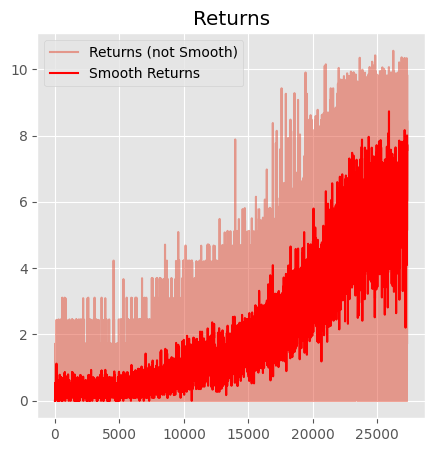

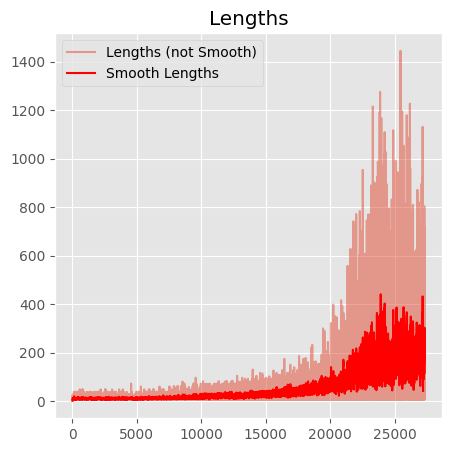

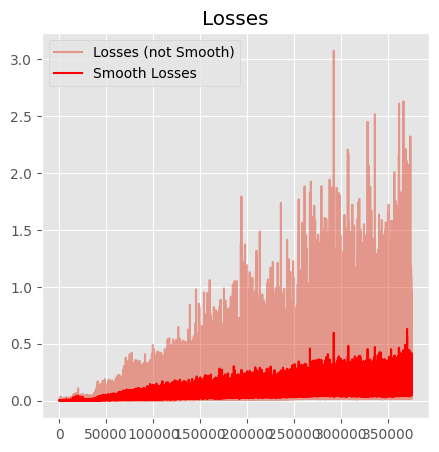

In [ ]:
#smooth returns
window_size = 10
smooth_returns = rolling_average(returns,window_size)
smooth_lengths = rolling_average(lengths,window_size)
smooth_losses = rolling_average(losses,window_size)

# Returns
plt.figure(figsize=(5, 5))
plt.plot(returns, label='Returns (not Smooth)', alpha=0.5)
plt.plot(smooth_returns, label='Smooth Returns', color='red')
plt.title('Returns')
plt.legend()
plt.show()

# Lengths
plt.figure(figsize=(5, 5))
plt.plot(lengths, label='Lengths (not Smooth)', alpha=0.5)
plt.plot(smooth_lengths, label='Smooth Lengths', color='red')
plt.title('Lengths')
plt.legend()
plt.show()

# Losses
plt.figure(figsize=(5, 5))
plt.plot(losses, label='Losses (not Smooth)', alpha=0.5)
plt.plot(smooth_losses, label='Smooth Losses', color='red')
plt.title('Losses')
plt.legend()
plt.show()

In [ ]:
import pickle
#grab the returns, lengths and losses and dump into pickle files for later
with open('returns_DDQN.pkl', 'wb') as f:
  pickle.dump(returns, f)

with open('lengths_DDQN.pkl', 'wb') as f:
  pickle.dump(lengths, f)

with open('losses_DDQN.pkl', 'wb') as f:
  pickle.dump(losses, f)

with open('q_DDQN.pkl', 'wb') as f:
  pickle.dump(q, f)

with open('next_q_DDQN.pkl', 'wb') as f:
  pickle.dump(next_q, f)

with open('tot_actions_DDQN.pkl', 'wb') as f:
  pickle.dump(tot_actions, f)

# Render Game

In [ ]:
# Fixed Render Function
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(state):
            return env.action_space.sample()

    state = env.reset()[0]
    img = plt.imshow(env.render())
    plt.axis('off')

    while True:
        action = policy(state)
        state, _, done, _,_ = env.step(action)
        img.set_data(env.render())
        display(plt.gcf())
        clear_output(wait=True)

        if done:
            break

    env.close()
    clear_output(wait=True)

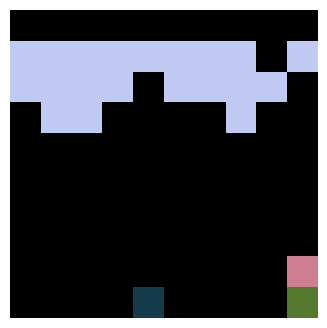

In [ ]:
buttons_all = []
for key_env, env in envs.items():
    try:
        checkpoint = torch.load(f'checkpoint_breakout_DDQN.pt')
    except FileNotFoundError:
        pass
    else:
        buttons = []
        for key, value in checkpoint.items():
            dqn = DQN.custom_load(value)

            def make_callback(env, dqn):
                def button_callback(button):
                    for b in buttons_all:
                        b.disabled = True

                    render(env,
                           lambda
                           state:
                           dqn(
                              torch.tensor(state, dtype=torch.float).permute(2,0,1).unsqueeze(0)
                           ).argmax().item())

                    for b in buttons_all:
                        b.disabled = False

                return button_callback

            button = widgets.Button(description=f'{key.replace("_", ".")}%')
            button.on_click(make_callback(env, dqn))
            buttons.append(button)

        print(f'{key_env}:')
        display(widgets.HBox(buttons))
        buttons_all.extend(buttons)